<a href="https://colab.research.google.com/github/amir-asari/SEBB4083-AI--202220232/blob/main/SEBB4083_VGG16_transferlearning2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (Section 1)Transfer learning using VGG16 pretrained model

There are 2 approaches in performing transfer learning

1. Feature extraction:  Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

2. Fine-tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.



### Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

!pip install zipfile
from zipfile import ZipFile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


###Data preprocessing



####Download data from gdrive link

In [ ]:
! gdown --id 1YSRzwDWQJAyy2-7fX8qH4jzQef-QJFQG

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YSRzwDWQJAyy2-7fX8qH4jzQef-QJFQG
To: /content/dronedataset.zip
100% 1.57G/1.57G [00:21<00:00, 74.1MB/s]


####Unzip the download file

In [ ]:
with ZipFile('/content/dronedataset.zip','r') as zipObj:
  zipObj.extractall()

####Load data using Keras utility

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

Create a dataset

Define some parameters for the ImageDataGenerator:

In [ ]:
batch_size = 50 # Of course here, we are using mini-batch gradient descent 
img_height = 224
img_width = 224

Data splitting, into 70% training data and 30% testing data. Once splitted, all data will saved in folder called training_data and testing_data

In [ ]:
# Define the path to your dataset directory
dataset_dir = '/content/dronedataset'

# Define the path to the directory where you want to create the train and test folders
output_dir = '/content/output'

# Define the percentage of data to be used for testing
test_split = 0.3

# Get the list of subfolders in the dataset directory
subfolders = [subfolder for subfolder in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, subfolder))]

print(subfolders)

# Define the train and test folder paths
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Delete train and test folders if they already exist
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Create the train and test folders in the output directory
os.makedirs(train_dir)
os.makedirs(test_dir)

# Iterate over each subfolder and split the images into train and test sets
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_dir, subfolder)
    images = os.listdir(subfolder_path)
    train_images, test_images = train_test_split(images, test_size=test_split, random_state=42)

    # Create the subfolders inside train and test directories
    train_subfolder_dir = os.path.join(train_dir, subfolder)
    test_subfolder_dir = os.path.join(test_dir, subfolder)
    os.makedirs(train_subfolder_dir)
    os.makedirs(test_subfolder_dir)
    
    # Move the train images to the train folder
    for image in train_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(train_dir, subfolder, image)
        print(src)
        print(dst)
        shutil.copyfile(src, dst)
    
    # Move the test images to the test folder
    for image in test_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(test_dir, subfolder, image)
        shutil.copyfile(src, dst)

Streaming output truncated to the last 5000 lines.
/content/dronedataset/No_Fire/lake_resized_lake_frame8700.jpg
/content/output/train/No_Fire/lake_resized_lake_frame8700.jpg
/content/dronedataset/No_Fire/lake_resized_lake_frame4036.jpg
/content/output/train/No_Fire/lake_resized_lake_frame4036.jpg
/content/dronedataset/No_Fire/resized_frame17208.jpg
/content/output/train/No_Fire/resized_frame17208.jpg
/content/dronedataset/No_Fire/lake_resized_lake_frame3532.jpg
/content/output/train/No_Fire/lake_resized_lake_frame3532.jpg
/content/dronedataset/No_Fire/lake_resized_lake_frame1345.jpg
/content/output/train/No_Fire/lake_resized_lake_frame1345.jpg
/content/dronedataset/No_Fire/resized_test_nofire_frame1342.jpg
/content/output/train/No_Fire/resized_test_nofire_frame1342.jpg
/content/dronedataset/No_Fire/lake_resized_lake_frame5748.jpg
/content/output/train/No_Fire/lake_resized_lake_frame5748.jpg
/content/dronedataset/No_Fire/resized_frame3538.jpg
/content/output/train/No_Fire/resized_frame

In [ ]:
# Define the path to the subfolder containing the images
test_fire_path = '/content/output/test/Fire'
test_nofire_path = '/content/output/test/No_Fire'
train_fire_path = '/content/output/train/Fire'
train_nofire_path = '/content/output/train/No_Fire'

# Count the number of images in the subfolder
num_images1 = len([name for name in os.listdir(test_fire_path) if os.path.isfile(os.path.join(test_fire_path, name))])
num_images2 = len([name for name in os.listdir(test_nofire_path) if os.path.isfile(os.path.join(test_nofire_path, name))])
num_images3 = len([name for name in os.listdir(train_fire_path) if os.path.isfile(os.path.join(train_fire_path, name))])
num_images4 = len([name for name in os.listdir(train_nofire_path) if os.path.isfile(os.path.join(train_nofire_path, name))])

# Print the number of images in the subfolder
print(f"Number of images in the test/fire: {num_images1}")
print(f"Number of images in the test/nofire: {num_images2}")
print(f"Number of images in the train/fire: {num_images3}")
print(f"Number of images in the train/nofire: {num_images4}")

Number of images in the test/fire: 9047
Number of images in the test/nofire: 5352
Number of images in the train/fire: 21108
Number of images in the train/nofire: 12485


After that, create a `tf.keras.preprocessing.image.ImageDataGenerator` object which will handle the image dataset for training and testing.

Then the object function called `flow_from_directory` is used provide batch of image dataset according to specification based on function input argument. 

20% from the training data will be taken out and used as validation data

In [ ]:
# data_dir = '/content/dronedataset'
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   shuffle=True,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)


# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   shuffle=True,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)


# Create an instance of the ImageDataGenerator with for training and testing
train_data_generator = ImageDataGenerator( validation_split=0.2) # 20% from training will be leaved out for validation
test_data_generator = ImageDataGenerator()

names = ["Fire" , "No_Fire"] #make sure the spelling is similar to the folder name

# Create the train batch generator
train_batches = train_data_generator.flow_from_directory(
    '/content/output/train',
    target_size = (img_width,img_height),
    class_mode = 'sparse', #make label as integer value
    subset='training',
    batch_size = batch_size,
    shuffle = True,
    color_mode = "rgb",
    classes = names
)

# Create the validation batch generator
validation_batches = train_data_generator.flow_from_directory(
    '/content/output/train',
    target_size = (img_width,img_height),
    class_mode = 'sparse', #make label as integer value
    subset='validation',
    batch_size = batch_size,
    shuffle = True,
    color_mode = "rgb",
    classes = names
)


# Create the test generator
test_batches = test_data_generator.flow_from_directory(
    '/content/output/test',
    target_size = (224,224),
    class_mode = 'sparse', #make label as integer value
    batch_size = batch_size,
    shuffle = True,
    color_mode = "rgb",
    classes = names
)

Found 26875 images belonging to 2 classes.
Found 6718 images belonging to 2 classes.
Found 14399 images belonging to 2 classes.


### Visualize the data

Here are the first nine images from the training dataset:

(50, 224, 224, 3)
(50,)


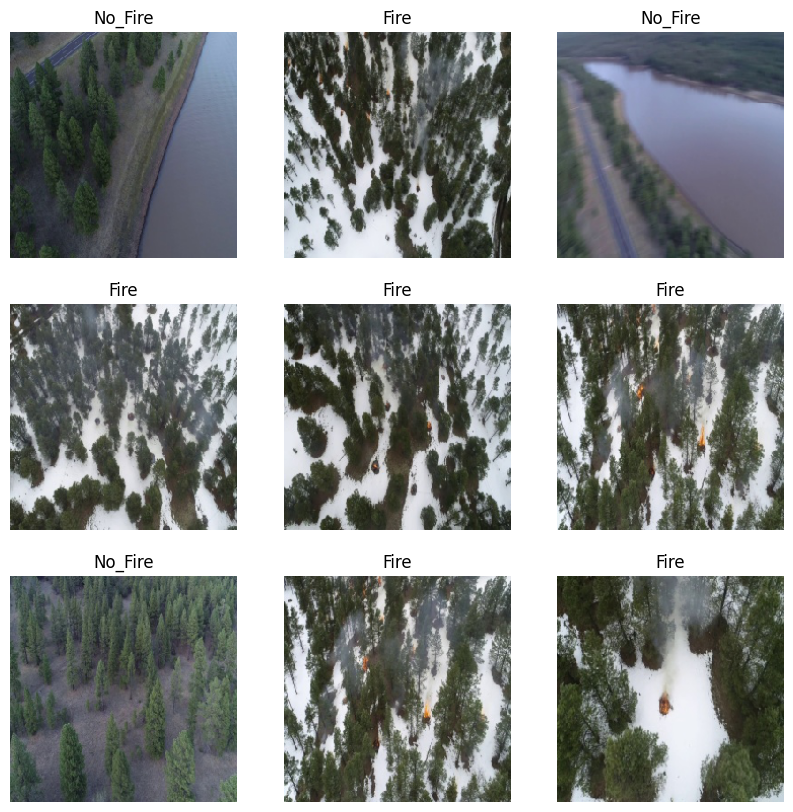

In [ ]:
import matplotlib.pyplot as plt

single_train_image_batch = train_batches.next()  #single_train_batch[0] -> image  single_train_batch [1] -> label
batch_images = single_train_image_batch[0]
batch_labels = single_train_image_batch[1]
print(batch_images.shape)
print(batch_labels.shape)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(batch_images[i].astype("uint8"))
  plt.title(names[batch_labels[i].astype("int")])
  plt.axis("off")

###Create the base model from the pre-trained VGG16

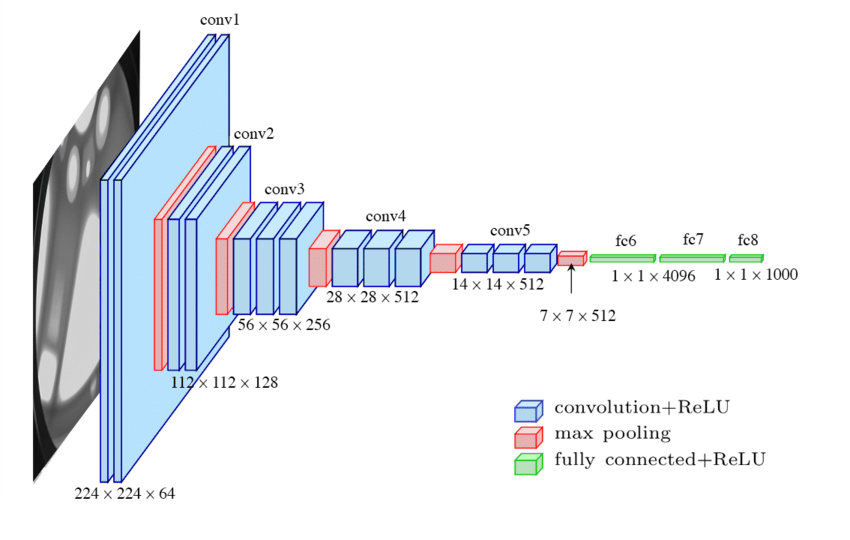

First, instantiate a VGG16 model pre-loaded with weights trained on ImageNet. 

In [ ]:
# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16()

# print(type(base_model))
print("****VGG16 original network arhitecture****")
base_model.summary()

553467096/553467096 [==============================] - 3s 0us/step
****VGG16 original network arhitecture****
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                 

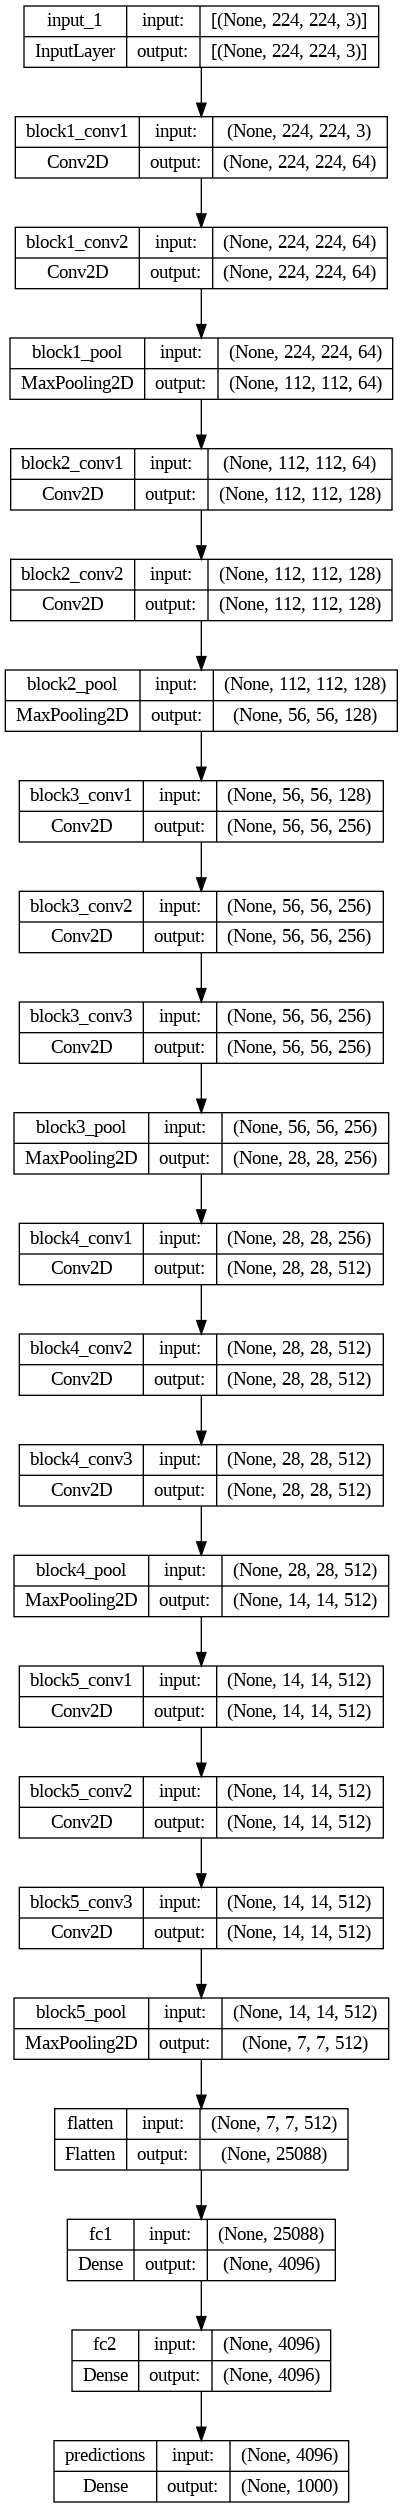

In [ ]:
tf.keras.utils.plot_model(base_model, to_file = 'VGG16_basemodel.png', show_shapes = True)

Create new model, copy all layers in VGG16 from the 1st until 2nd last layer

In [ ]:
#Create our model by copying from the 1st layer to the 2nd last layer

model = tf.keras.models.Sequential()
for layer in base_model.layers[0:-1]:
  model.add(layer)

print("****model after removing copy all VGG16 layers and remove the last layer****")
model.summary()

****model after removing copy all VGG16 layers and remove the last layer****
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                             

Add the last layer with new dense layer with 2 outputs replacing the dense layer with 1000 outputs

In [ ]:
#Freezing the existing weights
for layer in model.layers:
    layer.trainable = False
print(model.summary())

#add new layer which will replace the previous VGG16 last layer
model.add(tf.keras.layers.Dense(2))

print("****model after add new dense layer replacing the previous VGG16 last layer****")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

###Compile the model

Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [ ]:
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


###Train the model

In [ ]:
history = model.fit(train_batches,
                    epochs=3,
                    validation_data=validation_batches)

Epoch 1/3
538/538 [==============================] - 170s 315ms/step - loss: 0.0360 - accuracy: 0.9875 - val_loss: 0.2345 - val_accuracy: 0.9393
Epoch 2/3
538/538 [==============================] - 159s 295ms/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.2048 - val_accuracy: 0.9521
Epoch 3/3
538/538 [==============================] - 159s 295ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.1347 - val_accuracy: 0.9603


### Plot the learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

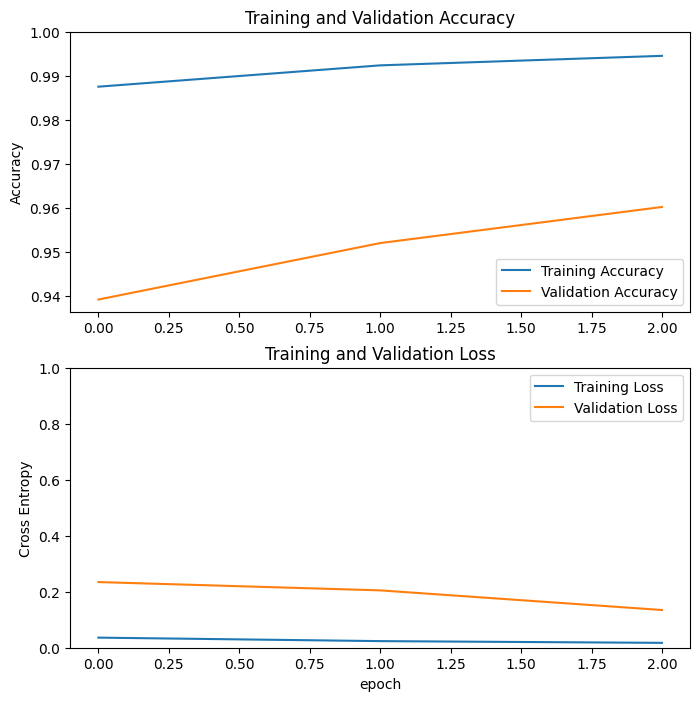

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Test the model

In [ ]:
# print(test_batches.shape)
test_loss, test_acc = model.evaluate(test_batches)

print('Test accuracy:', test_acc)

288/288 [==============================] - 70s 241ms/step - loss: 0.0445 - accuracy: 0.9858
Test accuracy: 0.985762894153595


Test the developed model in several test images and visual the image, the predicted label, actual label and the probability (in %)

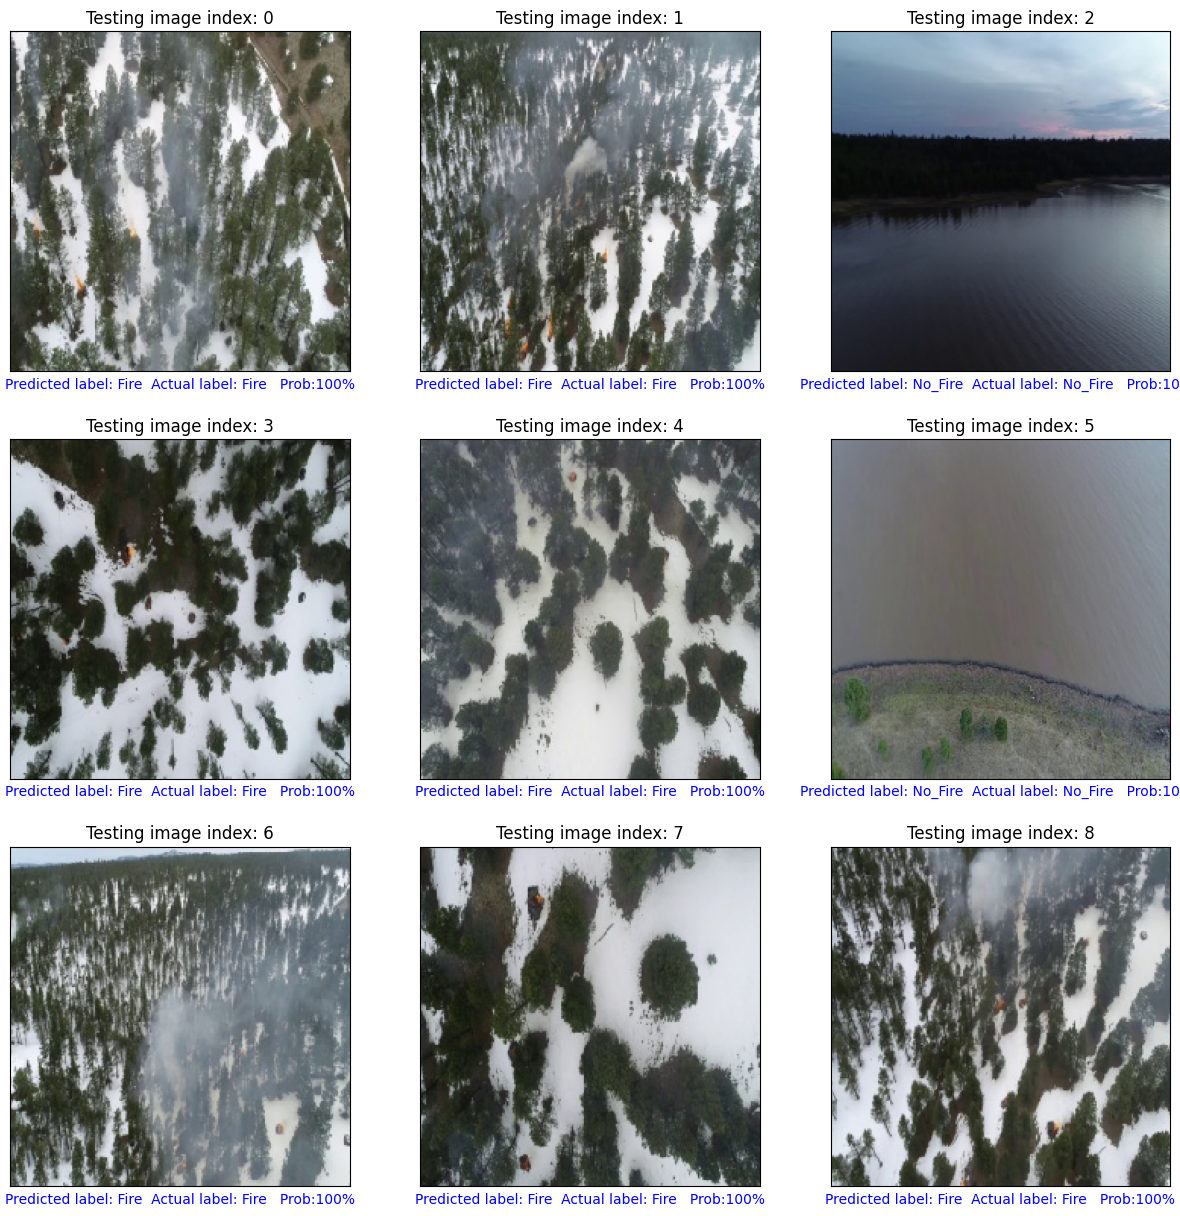

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i].astype("uint8"), img[i].astype("uint8")
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  predicted_label = np.argmax(predictions_array[i])
  
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("Predicted label: {}  Actual label: {}   Prob:{:2.0f}%".format(names[predicted_label],
                                names[true_label],
                                100*np.max(predictions_array)),
                                color=color)


single_test_image_batch = test_batches.next()
predicted_label_prob = model(single_test_image_batch[0]) # single_test_image_batch[0] -> batches of images; single_test_image_batch[1] -> batches of label
predicted_label_prob = tf.nn.softmax(predicted_label_prob)


plt.figure(figsize=(15, 15))
for index in range(9):
  ax = plt.subplot(3, 3, index + 1)
  plot_image(index,predicted_label_prob,single_test_image_batch[1],single_test_image_batch[0])
  plt.title("Testing image index: {}".format(index))

## (Section 2) Train your model with image/data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this tutorial.

In this case, an instance of `ImageDataGenerator` can be created to include with augmentation mechanism 

In [ ]:
# Create an instance of the ImageDataGenerator with desired augmentation options for training and validation
train_data_generator = ImageDataGenerator( validation_split=0.2,
                                          rotation_range = 20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          )

In [ ]:
# Create the train batch generator
train_batches = train_data_generator.flow_from_directory(
    '/content/output/train',
    target_size = (img_width,img_height),
    class_mode = 'sparse', #make label as integer value
    subset='training',
    batch_size = batch_size,
    shuffle = True,
    color_mode = "rgb",
    classes = names
)

Found 26875 images belonging to 2 classes.


In [ ]:
# import matplotlib.pyplot as plt

# single_train_image_batch = train_batches.next()  #single_train_batch[0] -> image  single_train_batch [1] -> label
# batch_images = single_train_image_batch[0]
# batch_labels = single_train_image_batch[1]
# print(batch_images.shape)
# print(batch_labels.shape)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(batch_images[i].astype("uint8"))
#   plt.title(names[batch_labels[i].astype("int")])
#   plt.axis("off")

### Recreate the model from VGG16

In [ ]:
#Create our model by copying from the 1st layer to the 2nd last layer

model = tf.keras.models.Sequential()
for layer in base_model.layers[0:-1]:
  model.add(layer)

### Freezen some layers and add last laser with dense layer (2 outputs)

In [ ]:
#Freezing the existing weights
for layer in model.layers:
    layer.trainable = False

#add new layer which will replace the previous VGG16 last layer
model.add(tf.keras.layers.Dense(2))


### Compile the model

In [ ]:
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [ ]:
history = model.fit(train_batches,
                    epochs=3,
                    validation_data=validation_batches)

Epoch 1/3
538/538 [==============================] - 399s 738ms/step - loss: 0.2034 - accuracy: 0.9214 - val_loss: 0.1205 - val_accuracy: 0.9559
Epoch 2/3
529/538 [============================>.] - ETA: 6s - loss: 0.1441 - accuracy: 0.9452